## Team Members:
- Mansour Allam
- Assaad Rabay

# Smoking Dependence Analysis
This notebook analyzes smoking dependence among university students using personality traits, lifestyle factors, and sociodemographic data. The aim is to predict smoking dependence and uncover hidden patterns in the dataset through machine learning techniques.

We will apply:
1. **Exploratory Data Analysis (EDA)**: Understand key variables and relationships.
2. **Supervised Learning**: Predict smoking dependence using Logistic Regression and Random Forest.
3. **Unsupervised Learning**: Identify participant clusters using PCA and K-Means.

The dataset represents anonymized responses collected from students and contains variables grouped into:
- **Personality traits** (Big Five model).
- **Smoking-related factors** (e.g., cigarette frequency, dependence).
- **Lifestyle and sociodemographic variables** (e.g., income, stress, exercise).


In [1]:
# # Smoking Dependence Analysis

# ## 1. Import Libraries
# Importing essential libraries for data analysis, visualization, and machine learning.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [2]:
# ## 2. Load Dataset
# Load the dataset containing survey responses. The dataset includes personality traits, smoking behaviors,
# and lifestyle variables.
df = pd.read_excel("2024_PersonalityTraits_SurveyData.xlsx")

# Display the first few rows to understand its structure
df.head()


,Unnamed: 0,Sector,Last page,Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?,"I see myself as someone who is extraverted, enthusiastic:","I see myself as someone who is critical, quarrelsome:","I see myself as someone who is dependable, self-disciplined:","I see myself as someone who is anxious, easily upset:",I see myself as someone who is open to new experiences:,"I see myself as someone who is reserved, quiet:",...,What type of income or financial support does your household receive?,What type of income or financial support does your household receive? [Comment],"If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange).",How would you describe your current income sufficiency?,"Including yourself, how many people currently live in your household?",To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?,How often do you exercise?,"On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?",How often do you feel stressed?,Employment Status
0,5,Private,5,Yes,Agree strongly,Disagree moderately,Agree strongly,Agree moderately,Agree strongly,Agree a little,...,Fully in Lebanese Lira,NaN,More than 20 million L.L,High: completely covers necessities with a few...,4,Very,Never,Between 2 and 3 hours,Frequently,Employed
1,11,Private,5,Yes,Agree moderately,Agree moderately,Agree moderately,Agree a little,Agree strongly,Disagree strongly,...,Fully in US Dollars,NaN,More than 20 million L.L,High: completely covers necessities with a few...,4,Slightly,Often or at least 3 days every week,Between 2 and 3 hours,Occasionally,Unemployed
2,14,Private,5,Yes,Disagree moderately,Neither agree nor disagree,Agree a little,Agree moderately,Disagree a little,Agree moderately,...,Fully in Lebanese Lira,NaN,I don't know,High: completely covers necessities with a few...,4,Moderately,Every day or at least 5 times every week,More than 4 hours,Constantly,Employed
3,15,Private,5,Yes,Agree strongly,Disagree moderately,Agree strongly,Disagree strongly,Agree strongly,Disagree moderately,...,Mixed,NaN,I don't know,Medium: covers all basic needs,5,Moderately,Often or at least 3 days every week,Between 2 and 3 hours,Occasionally,Employed
4,16,Private,5,Yes,Agree a little,Agree a little,Agree strongly,Disagree moderately,Agree moderately,Agree strongly,...,"Other, please specify",NaN,I prefer not to say,Medium: covers all basic needs,6,Slightly,Every day or at least 5 times every week,Less than 1 hour,Never,Employed


# Data Cleaning and Preprocessing
The dataset contains 48 columns, including personality traits, sociodemographics, and lifestyle habits. To prepare the data:
1. **Dropped Irrelevant Columns**: Removed sparse or irrelevant variables (e.g., comments).
2. **Encoded Personality Traits**: Likert-scale responses were mapped to numerical values (-2 to 3) for better interpretability.
3. **Encoded Yes/No Questions**: Converted binary questions into 0/1 for machine learning compatibility.
4. **Defined Target Variable**: Created `Smoking Dependence` (1 = High, 0 = Low) based on the time to first cigarette after waking up.
5. **Handled Missing Values**: Imputed missing numerical values with the mean and categorical values with the mode.

These steps ensure the dataset is ready for analysis and modeling.


In [3]:
# ## 3. Data Cleaning and Preprocessing
# Cleaning involves removing irrelevant columns, encoding categorical data, and handling missing values.

# Drop irrelevant columns
columns_to_drop = [
    "Unnamed: 0",
    "What is your current employment status? [Comment]",
    "What is your current marital status? [Comment]",
    "What is your main source of income? [Comment]",
    "What type of income or financial support does your household receive? [Comment]",
]
df_cleaned = df.drop(columns=columns_to_drop)

# Encode Likert-scale personality traits
likert_mapping = {
    "Disagree strongly": -2,
    "Disagree moderately": -1,
    "Neither agree nor disagree": 0,
    "Agree a little": 1,
    "Agree moderately": 2,
    "Agree strongly": 3,
}
personality_traits = [col for col in df_cleaned.columns if col.startswith("I see myself")]
for col in personality_traits:
    df_cleaned[col] = df_cleaned[col].map(likert_mapping)

# Encode Yes/No questions into binary values
binary_mapping = {"Yes": 1, "No": 0}
binary_columns = [
    "Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?",
    "Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?",
    "Do you smoke more frequently during the first hours after waking up than during the rest of the day? ",
    "Do you smoke if you are so ill that you are in bed most of the day?",
]
for col in binary_columns:
    df_cleaned[col] = df_cleaned[col].map(binary_mapping)

# Define Smoking Dependence as the target variable
dependence_mapping = {
    "Within 5 minutes": 1,  # High dependence
    "6 to 30 minutes": 1,   # High dependence
    "31 to 60 minutes": 0,  # Low dependence
    "After 60 minutes": 0   # Low dependence
}
df_cleaned["Smoking Dependence"] = df_cleaned["How soon after you wake up do you smoke your first cigarette?"].map(dependence_mapping)
df_cleaned.drop(columns=["How soon after you wake up do you smoke your first cigarette?"], inplace=True)

# Handle missing values
numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].mean())
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna(df_cleaned[categorical_columns].mode().iloc[0])

# Display cleaned data info
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 43 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Sector                                                                                                                                                                            212 non-null    object 
 1   Last page                                                                                                                                                                         212 non-null    int64  
 2   Have you smoked at least one full tobacco cigarette (excluding

# Exploratory Data Analysis
EDA is essential to understand the dataset and uncover meaningful patterns:
1. **Correlation Heatmap**:
   - Displays relationships between numerical variables.
   - Highlights potential predictors for smoking dependence (e.g., anxiety, dependability).
2. **Smoking Dependence Distribution**:
   - Visualizes the class imbalance in the target variable.
   - Shows more participants with low dependence (0) compared to high dependence (1).
3. **Boxplot of Personality Traits**:
   - Compares trait scores between low and high dependence groups.
   - Indicates that higher anxiety is associated with high dependence, while dependability and emotional stability are linked to low dependence.


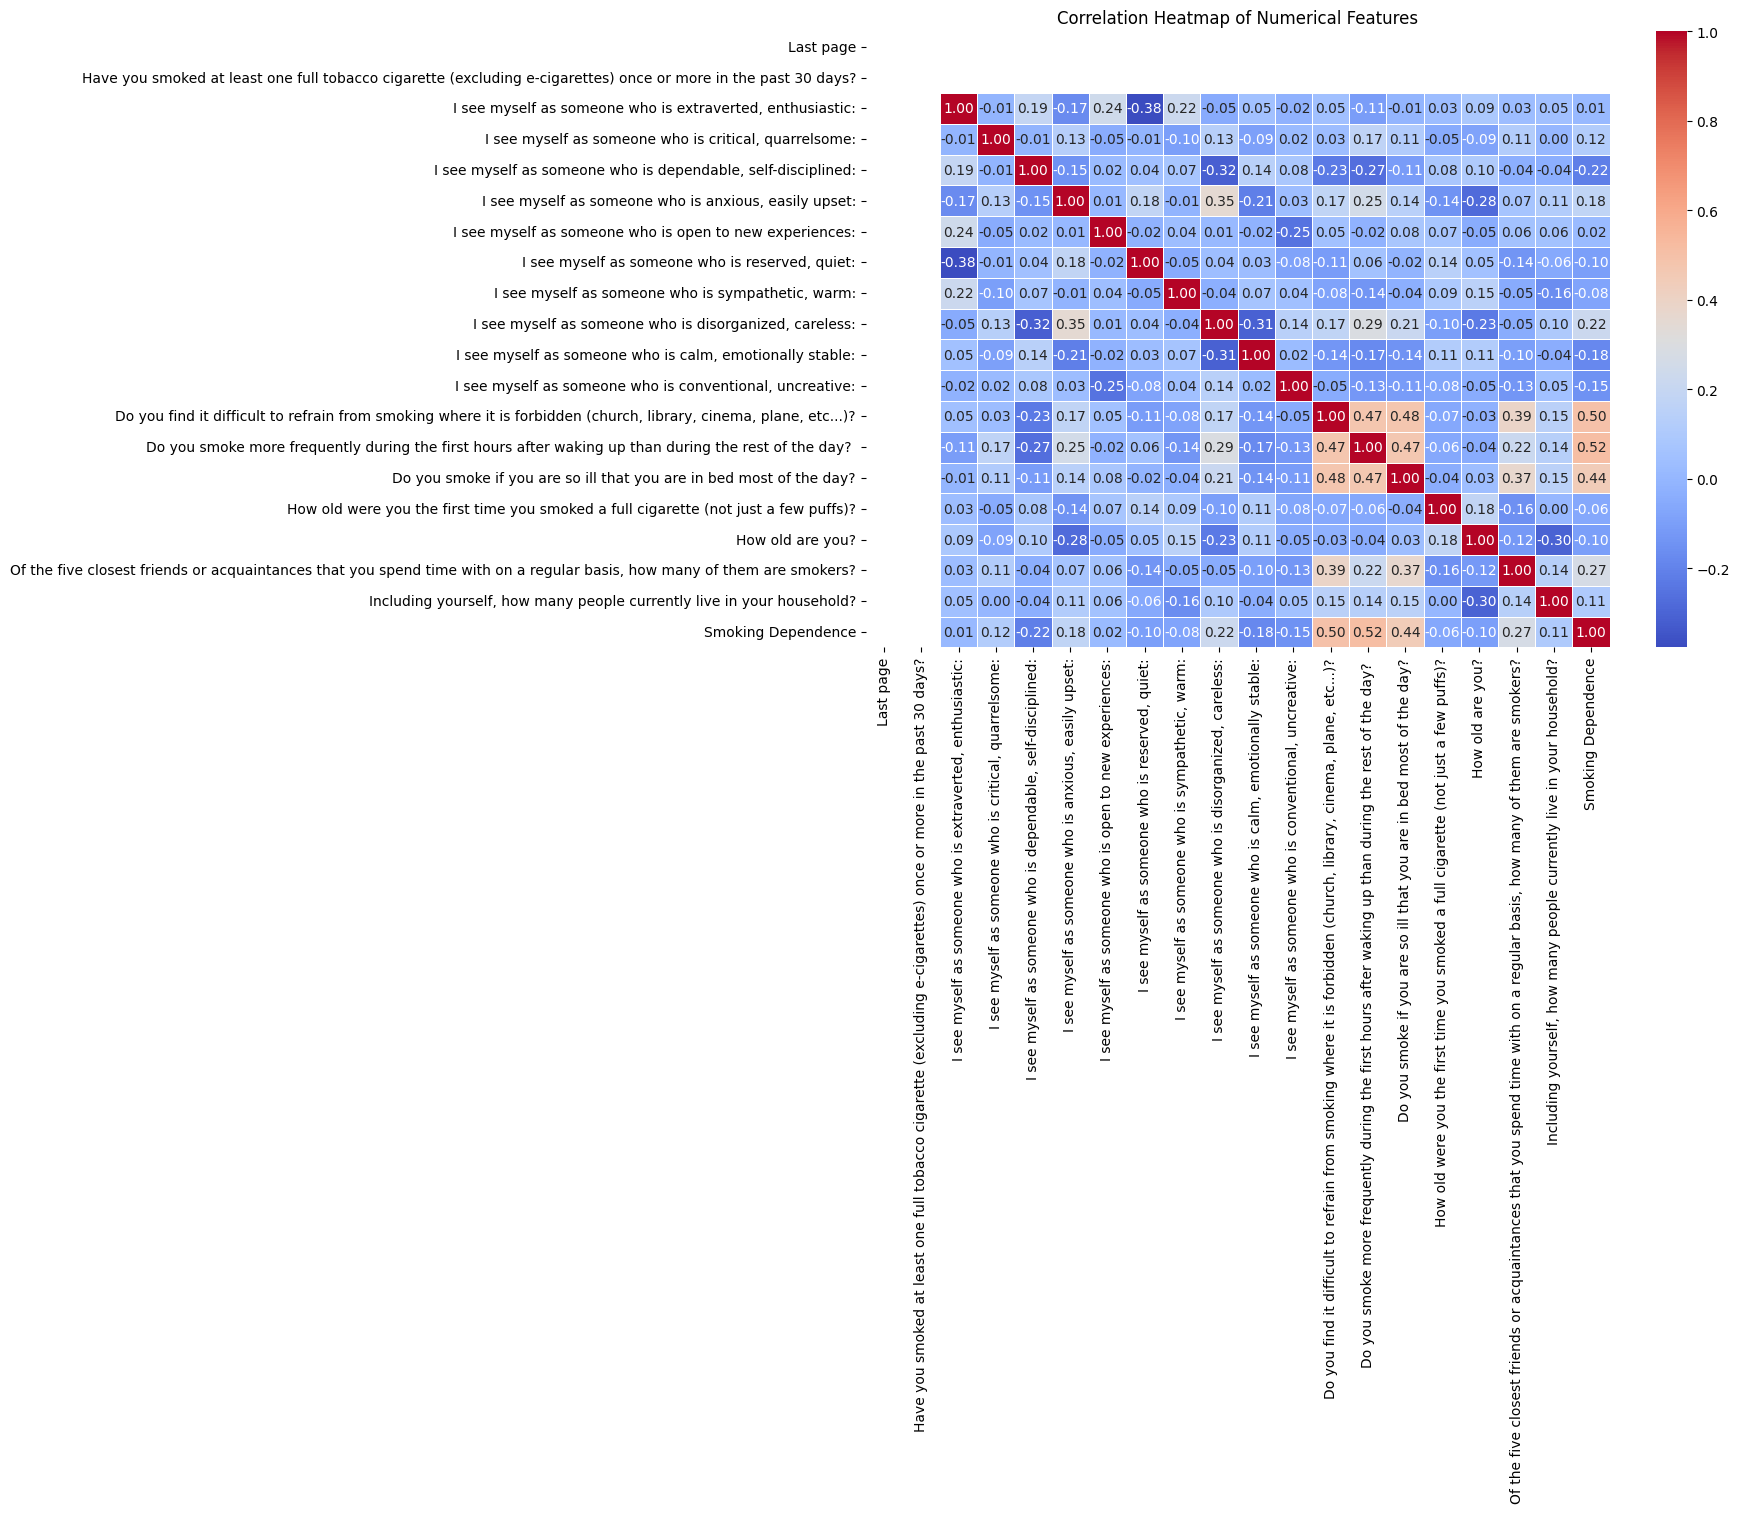

In [4]:
# ## 4. Exploratory Data Analysis (EDA)

# ### Correlation Heatmap
# This visualization shows the relationships between numerical features and identifies potential predictors for smoking dependence.
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


<ipython-input-5-376ba5a0a0f4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x="Smoking Dependence", palette="Set2")


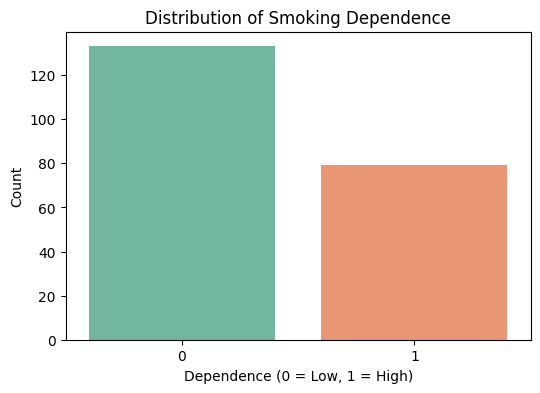

In [5]:
# ### Smoking Dependence Distribution
# Visualize the class imbalance in the target variable.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x="Smoking Dependence", palette="Set2")
plt.title("Distribution of Smoking Dependence")
plt.xlabel("Dependence (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.show()


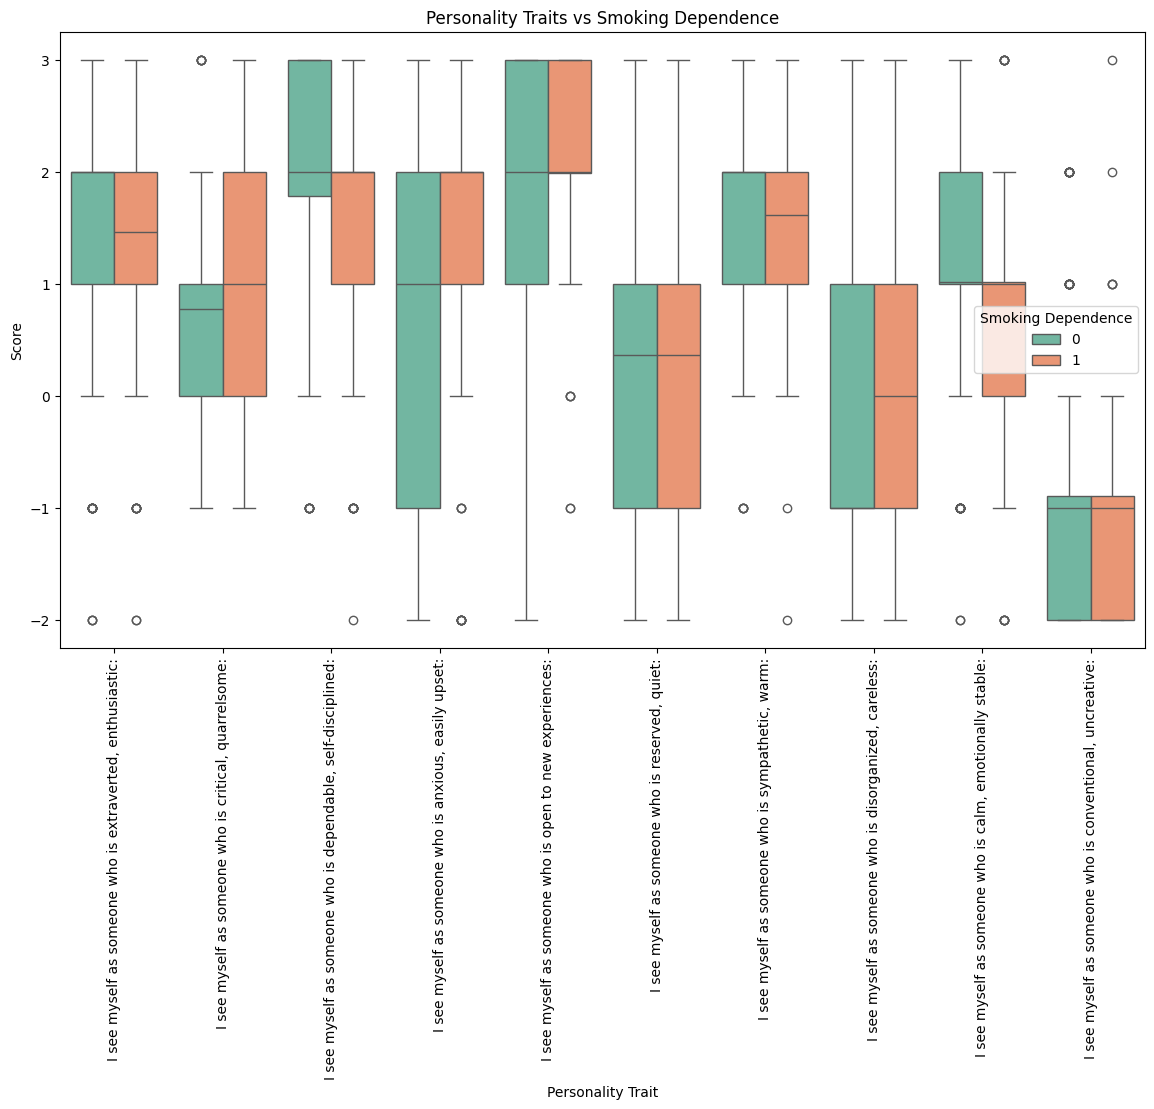

In [6]:
# ### Personality Traits vs Smoking Dependence
# Explore differences in personality traits between participants with low and high smoking dependence.
plt.figure(figsize=(14, 8))
melted_df = df_cleaned.melt(
    id_vars=["Smoking Dependence"],
    value_vars=personality_traits,
    var_name="Personality Trait",
    value_name="Score",
)
sns.boxplot(data=melted_df, x="Personality Trait", y="Score", hue="Smoking Dependence", palette="Set2")
plt.xticks(rotation=90)
plt.title("Personality Traits vs Smoking Dependence")
plt.show()


# Supervised Learning
We aim to predict `Smoking Dependence` using two models:

### Logistic Regression
- A simple baseline model for binary classification.
- Provides interpretability by highlighting the relationship between features and the target.

**Results**:
- Accuracy: 67%
- ROC-AUC: 0.72
- Shows moderate predictive power but is limited by linear assumptions.

---

### Random Forest
- A more advanced model that captures non-linear relationships.
- Identifies feature importance to explain key predictors of smoking dependence.

**Results**:
- Accuracy: 70%
- ROC-AUC: 0.73
- Top Predictors:
  - **Dependability**: Negatively correlated with dependence.
  - **Anxiety**: Strongly associated with high dependence.
  - **Emotional Stability**: Higher scores predict lower dependence.


In [7]:
# ## 5. Supervised Learning

# ### Define Features and Target Variable
features = personality_traits + [
    "How often do you feel stressed?",
    "On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?",
    "How often do you exercise?",
    "To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?",
    "How would you describe your current income sufficiency?",
]
X = pd.get_dummies(df_cleaned[features], drop_first=True)
y = df_cleaned["Smoking Dependence"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# ### Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        27
           1       0.56      0.62      0.59        16

    accuracy                           0.67        43
   macro avg       0.66      0.66      0.66        43
weighted avg       0.68      0.67      0.68        43

ROC-AUC Score: 0.7199074074074074



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        27
           1       0.62      0.50      0.55        16

    accuracy                           0.70        43
   macro avg       0.67      0.66      0.66        43
weighted avg       0.69      0.70      0.69        43

ROC-AUC Score: 0.7268518518518519


<ipython-input-9-36725405a6f2>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature", palette="viridis")


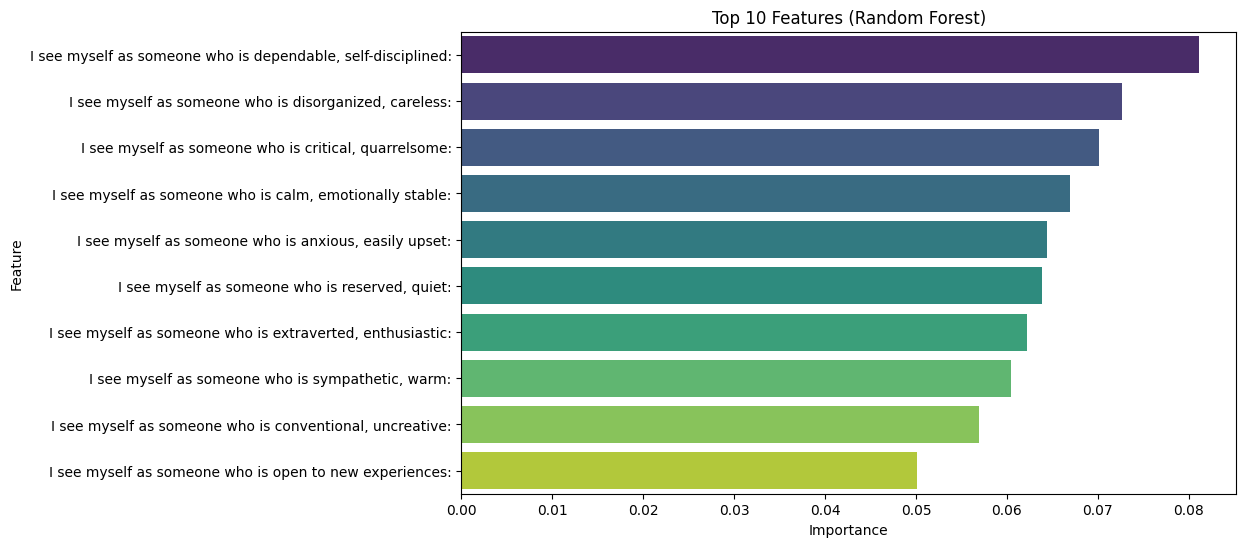

In [9]:
# ### Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

# Feature Importance Visualization
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_,
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Features (Random Forest)")
plt.show()


# Feature Importance Analysis
Random Forest identifies the most influential features for predicting smoking dependence. Key insights:
1. **Dependability and Emotional Stability**: Traits associated with low dependence.
2. **Anxiety**: Strongly linked to high dependence.
3. **Lifestyle Factors**: Stress and social media usage have minor impacts.

Feature importance helps prioritize variables for future interventions and behavioral research.


# Unsupervised Learning: Clustering
To explore hidden patterns in the dataset:
1. **PCA**: Reduced high-dimensional data into two components for visualization.
2. **K-Means Clustering**: Grouped participants based on personality traits and lifestyle factors.

**Clusters**:
- **Cluster 0**: Emotionally stable, highly disciplined, with better income sufficiency.
- **Cluster 1**: High anxiety, financial stress, and lower emotional stability.
- **Cluster 2**: Open to new experiences, with moderate discipline and variable exercise patterns.

The clustering analysis highlights distinct participant groups and their behavioral traits, aiding in targeted interventions.


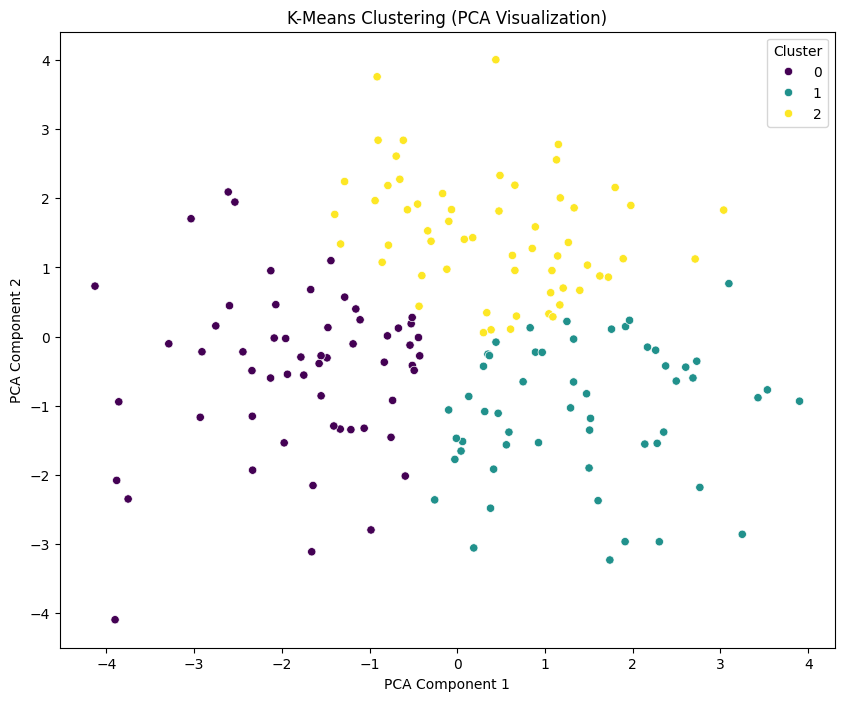


Cluster Characteristics:
         I see myself as someone who is extraverted, enthusiastic:  \
Cluster                                                              
0                                                 1.426268           
1                                                 0.845846           
2                                                 1.936160           

         I see myself as someone who is critical, quarrelsome:  \
Cluster                                                          
0                                                 0.502232       
1                                                 0.843086       
2                                                 0.978474       

         I see myself as someone who is dependable, self-disciplined:  \
Cluster                                                                 
0                                                 2.206735              
1                                                 1.183696              


In [10]:
# ## 6. Unsupervised Learning

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_scaled)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualize Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="viridis", legend="full")
plt.title("K-Means Clustering (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Cluster Analysis
cluster_analysis = pd.DataFrame(X_train).assign(Cluster=clusters).groupby("Cluster").mean()
print("\nCluster Characteristics:")
print(cluster_analysis)


# Final Insights and Recommendations
1. **Smoking Dependence Prediction**:
   - Logistic Regression provides baseline insights, while Random Forest offers better predictive accuracy.
   - Key predictors include **anxiety**, **dependability**, and **emotional stability**.
   - These traits can inform personalized smoking cessation programs.

2. **Clustering**:
   - Clusters reveal behavioral and psychological differences among participants.
   - **Cluster 1** (high anxiety and financial stress) may benefit most from targeted interventions.

3. **Actionable Steps**:
   - Develop tailored strategies for each cluster.
   - Incorporate personality-driven approaches to reduce smoking dependence.
